In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pydub import AudioSegment
import librosa
from matplotlib import pyplot as plt
import librosa.display
import IPython.display as ipd

In [2]:
def load_test_clip(path, start_time, duration=5):
    return librosa.load(path, offset=start_time, duration=duration)

In [5]:
FOLDER = '/home/usuario/birds/birdsong-recognition/'
TEST_FOLDER = FOLDER + 'test_audio/'
TRAIN_FOLDER = FOLDER + 'train_audio/'
EXAMPLE_FOLDER = FOLDER + 'example_test_audio/'

In [6]:
train = pd.read_csv(FOLDER+'train.csv')
# test = pd.read_csv(FOLDER+'test.csv')
# example_test_audio_metadata = pd.read_csv(FOLDER+'example_test_audio_metadata.csv')
# submit = pd.read_csv(FOLDER+'sample_submission.csv')
# example_test_audio_summary = pd.read_csv(FOLDER+'example_test_audio_summary.csv')

In [7]:
# example_test_audio_metadata

In [8]:
def get_example_clip(index = 1):
    start_time = example_test_audio_metadata['time_start'][index]
    time_end = example_test_audio_metadata['time_end'][index]
    duration = time_end - start_time
    translate_dict = {'BLKFR-10-CPL_20190611_093000': 'BLKFR-10-CPL_20190611_093000.pt540.mp3', 'ORANGE-7-CAP_20190606_093000':'ORANGE-7-CAP_20190606_093000.pt623.mp3'}
    path = EXAMPLE_FOLDER + translate_dict[example_test_audio_metadata['file_id'][index]]
    # BLKFR-10-CPL_20190611_093000.pt540.mp3  ORANGE-7-CAP_20190606_093000.pt623.mp3
    sound_clip, sr = load_test_clip(path, start_time, duration=duration)
    return sound_clip, sr
# sound_clip, rate = get_example_clip(253)
# ipd.Audio(sound_clip, rate=rate)

In [9]:
# from pydub.silence import split_on_silence
# dataframe = train[train['ebird_code']=='amecro'].iloc[0]
# filename = TRAIN_FOLDER+dataframe['ebird_code']+'/'+dataframe['filename']
# sound = AudioSegment.from_mp3(filename)

In [10]:
def get_train_clip(dataframe, resample=None):
    filename = TRAIN_FOLDER+dataframe['ebird_code']+'/'+dataframe['filename']
    sound = AudioSegment.from_mp3(filename)
    orig_sr = sound.frame_rate
    if resample is not None:
        sound = sound.set_frame_rate(resample)
    clip = sound.get_array_of_samples()
    duration = sound.duration_seconds

    clip = np.array(clip)
    clip = (clip - clip.mean())/np.abs(clip).max()
    return clip, orig_sr, duration

def get_spectrum(x):
    X = librosa.stft(x, )
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    return Xdb

# x, sr, duration = get_train_clip(train[train['ebird_code']=='ameavo'].iloc[0], 8000)

# Xdb = get_spectrum(x)
# plt.figure(figsize=(14, 5))
# plt.plot(np.log10(1/65535+x**2))
# print(sr)
# ipd.Audio(x, rate=sr)

In [11]:
birds_codes = train['ebird_code'].unique()
print(birds_codes[:100])

['aldfly' 'ameavo' 'amebit' 'amecro' 'amegfi' 'amekes' 'amepip' 'amered'
 'amerob' 'amewig' 'amewoo' 'amtspa' 'annhum' 'astfly' 'baisan' 'baleag'
 'balori' 'banswa' 'barswa' 'bawwar' 'belkin1' 'belspa2' 'bewwre' 'bkbcuc'
 'bkbmag1' 'bkbwar' 'bkcchi' 'bkchum' 'bkhgro' 'bkpwar' 'bktspa' 'blkpho'
 'blugrb1' 'blujay' 'bnhcow' 'boboli' 'bongul' 'brdowl' 'brebla' 'brespa'
 'brncre' 'brnthr' 'brthum' 'brwhaw' 'btbwar' 'btnwar' 'btywar' 'buffle'
 'buggna' 'buhvir' 'bulori' 'bushti' 'buwtea' 'buwwar' 'cacwre' 'calgul'
 'calqua' 'camwar' 'cangoo' 'canwar' 'canwre' 'carwre' 'casfin' 'caster1'
 'casvir' 'cedwax' 'chispa' 'chiswi' 'chswar' 'chukar' 'clanut' 'cliswa'
 'comgol' 'comgra' 'comloo' 'commer' 'comnig' 'comrav' 'comred' 'comter'
 'comyel' 'coohaw' 'coshum' 'cowscj1' 'daejun' 'doccor' 'dowwoo' 'dusfly'
 'eargre' 'easblu' 'easkin' 'easmea' 'easpho' 'eastow' 'eawpew' 'eucdov'
 'eursta' 'evegro' 'fiespa' 'fiscro']


In [12]:
import os

In [13]:
dataset_folder = './dataset/'

In [14]:
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

In [15]:
def get_bird_data(ebird_code, target_sr = 22050, chunk_seconds=2):
    total_duration = 0
    srs = []
    ratings = []
    df_aldfly = train[train['ebird_code']==ebird_code]
    durations = []
    chunk_size = chunk_seconds*target_sr
    x_reshaped = []
    ebird_folder = dataset_folder + ebird_code + '/'
    if not os.path.exists(ebird_folder):
        os.makedirs(ebird_folder)
    for i in range(len(df_aldfly)):
        df_row = df_aldfly.iloc[i]
        rating = df_row['rating']
        ratings.append(rating)
        if rating>=4:
            dataframe = df_aldfly.iloc[i]
            x, orig_sr, duration = get_train_clip(dataframe, target_sr)
            x = x[:(len(x)//chunk_size)*chunk_size].reshape(-1, chunk_size)
            x_reshaped.append(x)
            srs.append(orig_sr)
            durations.append(duration)
            total_duration = total_duration + duration
            print(f'\r{i}, {orig_sr}, {duration}', end='')
            for j, row in enumerate(x):
                file_to_save = ebird_folder + ''.join(dataframe['filename'].split('.')[:-1]) + f'_{j+1}.npy'
                if not os.path.exists(file_to_save):
                    np.save(file_to_save, row)
    return np.vstack(x_reshaped)

In [16]:
# ((299, 44100), (406, 44100)
# X_ameavo = get_bird_data('ameavo', target_sr = 22050, chunk_seconds=2)
# X_amebit = get_bird_data('amebit', target_sr = 22050, chunk_seconds=2)

In [17]:
# (3113, 44100), (4707, 44100), (2872, 44100))
# Largos
# ¿Quitarles el silencio del principio?
sr = 22050
X_amecro = get_bird_data('amecro', target_sr = 22050, chunk_seconds=2)

99, 44100, 162.56126984126982

In [18]:
X_aldfly = get_bird_data('aldfly', target_sr = 22050, chunk_seconds=2)

99, 44100, 9.9961904761904766

In [19]:
X_amegfi = get_bird_data('amegfi', target_sr = 22050, chunk_seconds=2)

99, 44100, 42.710204081632654

In [55]:
for row in X_amecro:
    print(row.shape)
    break

(44100,)


In [27]:
x = np.load('./dataset/amecro/XC233496_5.npy')

In [28]:
ipd.Audio(x, rate=sr)

In [1]:
dataset_folder = './dataset/'

In [8]:

from matplotlib import pyplot as plt

In [3]:
from birds_utils import DataGenerator, create_train_val_folders
dgen = DataGenerator(dataset_folder, batch_size=1024)

NameError: name 'dataset_folder' is not defined

In [6]:
for ba in dgen:
    print(ba[0].shape, ba[1].shape)
    break

(1024, 44100) (1024, 1)


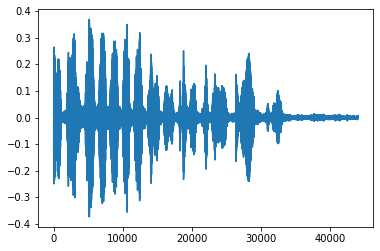

In [16]:
plt.plot(ba[0][4])

In [9]:
len(dgen)

11

In [50]:
X_amecro.shape

(4707, 44100)

In [48]:
labels = ['amecro', 'aldfly', 'amegfi']
X = np.vstack([X_amecro, X_aldfly, X_amegfi])
X = X.reshape(*X.shape,1)
y = np.array([0]*len(X_amecro) + [1]*len(X_aldfly) + [2]*len(X_amegfi))

In [49]:
X.shape

(10692, 44100, 1)

In [16]:
np.save('X_3_classes.npy', X)

In [17]:
np.save('y_3_classes.npy', y)

In [23]:
np.save('one_sample.npz',X[0].reshape(-1))

In [24]:
! ls -lah

total 3,6G
drwxrwxr-x  3 usuario usuario 4,0K jul  6 20:10 .
drwxrwxr-x 67 usuario usuario 4,0K jul  6 16:39 ..
-rw-rw-r--  1 usuario usuario 9,3K jul  6 20:09 1_Preprocess.ipynb
-rw-rw-r--  1 usuario usuario 702K jul  6 19:25 2_Model.ipynb
drwxrwxr-x  2 usuario usuario 4,0K jul  6 17:52 .ipynb_checkpoints
-rw-rw-r--  1 usuario usuario 345K jul  6 20:10 one_sample.npy
-rw-rw-r--  1 usuario usuario 345K jul  6 20:10 one_sample.npz.npy
-rw-rw-r--  1 usuario usuario 3,1M jul  6 19:24 weights_2048.hdf5
-rw-rw-r--  1 usuario usuario  17M jul  6 18:02 weights_fourier_2048.hdf5
-rw-rw-r--  1 usuario usuario 3,6G jul  6 17:54 X_3_classes.npy
-rw-rw-r--  1 usuario usuario  84K jul  6 17:55 y_3_classes.npy


In [1]:
from birds_utils import DataGenerator, create_train_val_folders
from glob import glob

In [2]:
dataset_folder = './dataset/'
create_train_val_folders(dataset_folder)

./dataset/train/
./dataset/val/


In [3]:
all_subfolder = 'all/'
train_subfolder = 'train/'
val_subfolder = 'val/'

In [4]:
dataset_folder_all = dataset_folder + all_subfolder
dataset_folder_train = dataset_folder + train_subfolder
dataset_folder_val = dataset_folder + val_subfolder

In [5]:
len(glob(dataset_folder_train+'**/*', recursive=True))

8557

In [6]:
len(glob(dataset_folder_val+'**/*', recursive=True))

2141

In [7]:
len(glob(dataset_folder_all+'**/*', recursive=True))

10695

In [50]:
audio_files_train.shape, audio_files_val.shape

((8554,), (2138,))